In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import dlib
import os
import dlib
import torchvision 
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
from torchvision.datasets import DatasetFolder
import torch.nn as nn
from tqdm.notebook import tqdm as tqdm

In [2]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print("CUDA is not available")
else:
    print("CUDA is available")
device = 'cuda' if train_on_gpu else 'cpu'

CUDA is available


In [3]:
train_path = '/home/max/Desktop/mask/train/'
valid_path = '/home/max/Desktop/mask/valid/'
test_path = '/home/max/Desktop/mask/test/'

In [4]:
# hyperparameters

batch_size = 32
n_epochs = 10
lr = 0.0005

In [5]:
# dataset



val_trans = transforms.Compose([transforms.Resize((256, 256)),transforms.ToTensor()])
val_data = ImageFolder(valid_path, transform = val_trans)
val_loader = DataLoader(val_data, shuffle = True)

test_trans = transforms.Compose([transforms.Resize((256, 256)),transforms.ToTensor()])
test_data = ImageFolder(test_path, transform = test_trans)
test_loader = DataLoader(test_data, shuffle = True)

face_trans = transforms.Compose([
                                  transforms.RandomHorizontalFlip(),
                                  transforms.Resize((256, 256)),
                                  transforms.ToTensor()
                                  ])
face_data = ImageFolder(train_path, transform = face_trans)
face_dataloader = DataLoader(face_data, pin_memory=True, batch_size=batch_size, shuffle=True)

In [6]:
print(len(val_data))
print(len(test_data))
print(len(face_data))

200
200
3704


tensor([1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        1, 1, 0, 0, 0, 0, 1, 1])


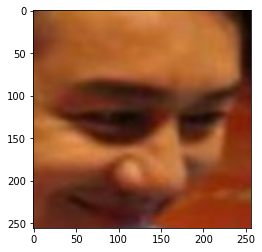

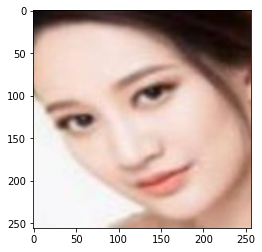

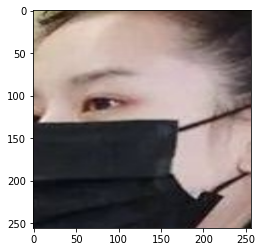

In [7]:
images, labels = next(iter(face_dataloader))
print(labels)
for i in np.arange(3):
#     print(images[i])
    plt.figure(i)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.show()

In [8]:
# 1. Input layer
# 2. Convolutional layer
# 3. ReLU layer
# 4. Pooling layer
# 5. Fully-connected layer
class Galaxy(nn.Module):
  def __init__(self):
    super(Galaxy, self).__init__()
    # input_shape = (3, 224, 224)
    # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, 
    #                 padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
    # in_channels: Input channels
    # out_channels: Output channels
    # kernel_size: Fillter size
    # stride: Each step our Fillter move
    # padding: We want our image can remain origin size
    self.cnn = nn.Sequential(
        ## CNN1
        nn.Conv2d(in_channels = 1, out_channels = 256, kernel_size = 3, stride = 1, padding = 1), # padding = kernel_size / 2
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (64, 112, 112)
        ## CNN2
        nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (128, 56, 56)
        ## CNN3
        nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (256, 28, 28)
        ## CNN4
        nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (512, 14, 14)
        ## CNN5
        nn.Conv2d(in_channels = 1024, out_channels = 1024, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)## (512, 7, 7)
        ## CNN6
#         nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 3, stride = 1, padding = 1),
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size = 2)## (1024, 3, 3)
    )
    self.fc = nn.Sequential(
        nn.Linear(1024 * 28 * 28, 512), # Fully-connected layer
        nn.Dropout(0.5), # Avoid overfitting
        nn.ReLU(),
        nn.Linear(512, 128),
#         nn.Dropout(0.1),
        nn.ReLU(),
#         nn.Linear(512, 256),
#         nn.Dropout(0.5),
#         nn.ReLU(),
    )
    self.out = nn.Linear(128, 8)
    
  # forward propagation
  def forward(self, x):
    x = self.cnn(x)
    print(x.shape)
    x = x.flatten(1)
    x = self.fc(x)
    output = self.out(x)
    return output, x

In [9]:
# model = Galaxy()
model = torchvision.models.vgg16(pretrained=False)
model = model.to(device)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.01)
loss_func = nn.CrossEntropyLoss()
# # reg = JacobianReg() # Jacobian regularization
# lambda_JR = 0.01 # hyperparameter
# l1_crit = nn.L1Loss(size_average=False)
# factor = 0.03
train_loss_record = []
train_acc_record = []
val_loss_record = []
val_acc_record = []
min_loss = 2000.
for epoch in range(n_epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_acc = 0.0
    val_acc = 0.0
    model.train()
    for x, y in tqdm(face_dataloader):
#         print(x.shape)
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
#         print(x.shape)
        prediction = model(x)
#         reg_loss = 0
#         reg_loss = l1_crit(prediction.argmax(dim = 1), y)
#         print(prediction.shape)
#         print(y.shape)
        loss = loss_func(prediction, y)
        
#         loss = super_loss + factor*reg_loss
        
        loss.backward()
        optimizer.step()
        
        acc = ((prediction.argmax(dim = 1) == y).float().mean())
        train_acc += acc/len(face_dataloader)
        train_loss += loss/len(face_dataloader)
        
    print(f"[ Train | {epoch+1}/{n_epochs} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    train_loss_record.append(train_loss.cpu().detach().numpy())
    train_acc_record.append(train_acc.cpu().detach().numpy())

    model.eval()
    for x, y in tqdm(val_loader):
        x, y = x.to(device), y.to(device)
        prediction = model(x)
        reg_loss = 0

#         reg_loss = l1_crit(prediction.argmax(dim = 1), y)
        
        loss = loss_func(prediction, y)
        
#         loss = super_loss + factor*reg_loss
        loss.backward()
        acc = ((prediction.argmax(dim = 1) == y).float().mean())
        val_acc += acc/len(val_loader)
        val_loss += loss/len(val_loader)
        
    if val_loss < min_loss:
        min_loss = val_loss
        torch.save(model, 'mask.pkl')
        print('save model')
    print(f"[ Validation | {epoch+1}/{n_epochs} ] loss = {val_loss:.5f}, acc = {val_acc:.5f}")
    val_loss_record.append(val_loss.cpu().detach().numpy())
    val_acc_record.append(val_acc.cpu().detach().numpy())

In [11]:
actu = []
ai_pred = []
model.eval()
test_acc = 0.0
test_loss = 0.0
for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    prediction = model(x)
    actu.append(y.to('cpu').numpy()[0])
    ai_pred.append(prediction.argmax().to('cpu').numpy().tolist())
    loss = loss_func(prediction, y)
    loss.backward()
    acc = ((prediction.argmax(dim = 1) == y).float().mean())
    test_acc += acc/len(test_loader)
    test_loss += loss/len(test_loader)
print(f"[ Test ] loss = {test_loss:.5f}, acc = {test_acc:.5f}")

[ Test ] loss = 0.12574, acc = 0.96500


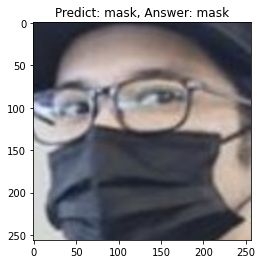

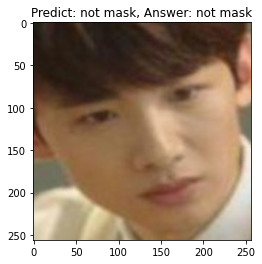

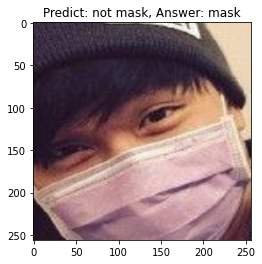

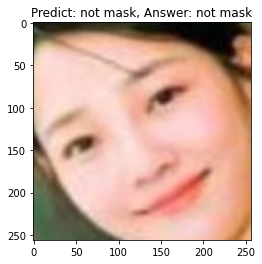

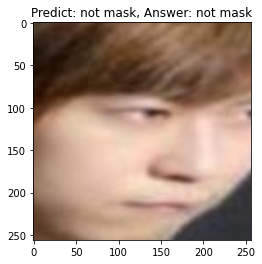

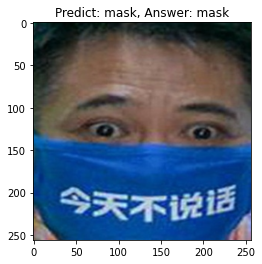

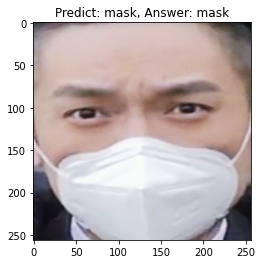

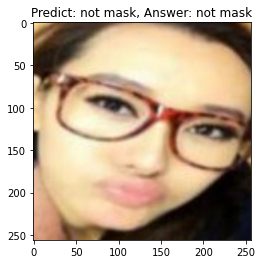

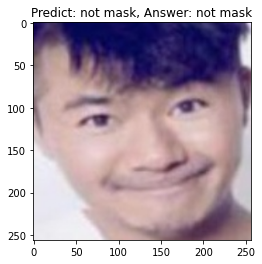

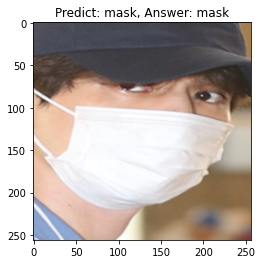

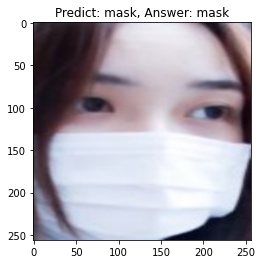

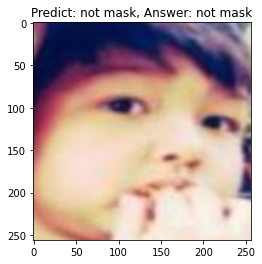

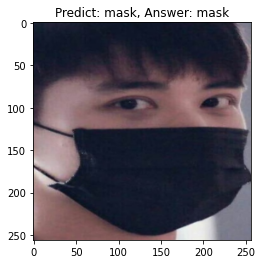

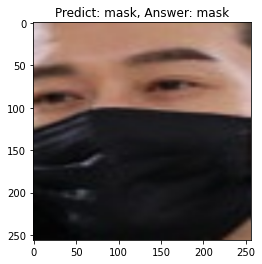

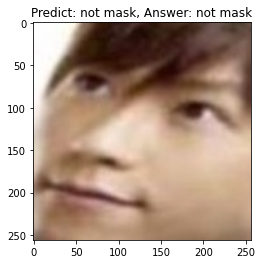

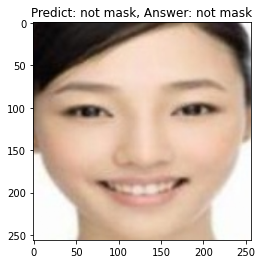

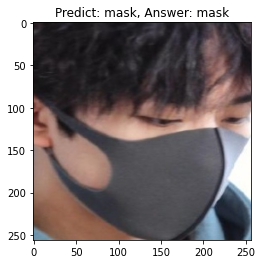

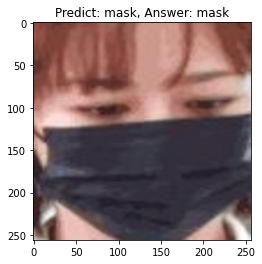

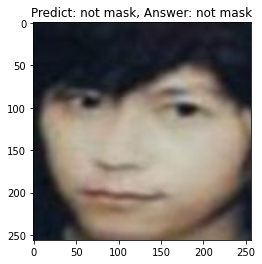

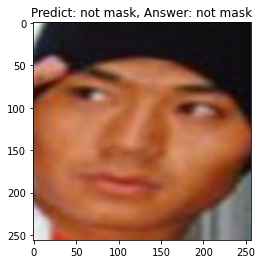

In [13]:
model = torch.load('mask.pkl')
mask_type = ['mask', 'not mask']
loss_func = nn.CrossEntropyLoss()
i = 0
for x, y in test_loader:
    i += 1
    if train_on_gpu:
        x, y = x.cuda(), y.cuda()
    output = model(x)
    out = output.argmax(dim = 1)
    out = out.to('cpu').numpy()
    ans = mask_type[y[0]]
    pre = mask_type[out[0]]
    if i % 10 == 0:
        
        plt.figure(i)
        plt.title(f'Predict: {pre}, Answer: {ans}')
#         if out[0] == 0:
            
#         elif out[0] == 1:
#             plt.title(f'Predict: {pre}, Answer: {ans}')
#         else:
#             plt.title(f'Predict: S, Answer: {ans}')
        x = x.squeeze()
        x = x.to('cpu')
        plt.imshow(x.permute(1, 2, 0))
        plt.show()